In [1]:
from lib.policy_guided_explorer import Explorer
from lib.implicit_mdp import PTO_wrapper
import pandas
import tqdm
import seaborn

In [2]:
from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model
from lib.models.generic_v0.model import mappable_params, map_params
from lib.models.generic_v1.protocols.bitcoin import Protocol as G1Bitcoin
from lib.models.generic_v1.protocols.ghostdag import Protocol as G1Ghostdag
from lib.models.generic_v1.model import SingleAgent as G1Model
from lib.models.aft20barzur import BitcoinSM as AFT20BarZur, ptmdp
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


add_model(
    model="aft20barzur",
    protocol="bitcoin",
    implicit_mdp=AFT20BarZur(**mappable_params, maximum_fork_length=999999),
)
add_model(
    model="fc16sapirshtein",
    protocol="bitcoin",
    implicit_mdp=FC16Sapirshtein(**mappable_params, maximum_fork_length=999999),
)
add_model(
    model="generic_v0/o",  # optimized
    protocol="bitcoin",
    implicit_mdp=G0Model(
        G0Bitcoin(),
        **mappable_params,
        maximum_size=999999,
        force_consider_own=True,
        merge_isomorphic=True,
    ),
)
add_model(
    model="generic_v1/o",  # optimized
    protocol="bitcoin",
    implicit_mdp=G1Model(
        G1Bitcoin,
        **mappable_params,
        force_consider_own=True,
        merge_isomorphic=True,
        collect_garbage=True,
        truncate_common_chain=True,
    ),
)
add_model(
    model="generic_v1/o",  # optimized
    protocol="ghostdag-1",
    implicit_mdp=G1Model(
        G1Ghostdag,
        k=1,
        **mappable_params,
        force_consider_own=True,
        merge_isomorphic=True,
        collect_garbage=True,
        truncate_common_chain=True,
    ),
)
add_model(
    model="generic_v1/o",  # optimized
    protocol="ghostdag-2",
    implicit_mdp=G1Model(
        G1Ghostdag,
        k=2,
        **mappable_params,
        force_consider_own=True,
        merge_isomorphic=True,
        collect_garbage=True,
        truncate_common_chain=True,
    ),
)
add_model(
    model="generic_v1/o",  # optimized
    protocol="ghostdag-3",
    implicit_mdp=G1Model(
        G1Ghostdag,
        k=3,
        **mappable_params,
        force_consider_own=True,
        merge_isomorphic=True,
        collect_garbage=True,
        truncate_common_chain=True,
    ),
)

pandas.DataFrame(models)

,model,protocol
0,aft20barzur,bitcoin
1,fc16sapirshtein,bitcoin
2,generic_v0/o,bitcoin
3,generic_v1/o,bitcoin
4,generic_v1/o,ghostdag-1
5,generic_v1/o,ghostdag-2
6,generic_v1/o,ghostdag-3


In [3]:
distance = 6
mappable_explicit_mdps = []

for i, imdp in enumerate(implicit_mdps):
    print(models[i], end="")

    exp = Explorer(imdp, imdp.honest)

    d = 0
    exp.explore_along_policy()

    while d < distance:
        exp.explore_aside_policy()
        exp.explore_along_policy()
        d += 1

    emdp = exp.mdp()
    mappable_explicit_mdps.append(emdp)
    print(f" n = {emdp.n_states}")

{'model': 'aft20barzur', 'protocol': 'bitcoin'} n = 69
{'model': 'fc16sapirshtein', 'protocol': 'bitcoin'} n = 66
{'model': 'generic_v0/o', 'protocol': 'bitcoin'} n = 2091
{'model': 'generic_v1/o', 'protocol': 'bitcoin'} n = 2237
{'model': 'generic_v1/o', 'protocol': 'ghostdag-1'} n = 13444
{'model': 'generic_v1/o', 'protocol': 'ghostdag-2'} n = 13444
{'model': 'generic_v1/o', 'protocol': 'ghostdag-3'} n = 13444


In [4]:
networks = []
for alpha in range(0, 51, 5):
    for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [5]:
horizon = 100
stop_delta = (
    0.0001 * horizon
)  # value iteration stops when no value estimate changes more than this value

with tqdm.tqdm(total=len(networks) * len(models)) as pbar:
    rows = []
    for network in networks:
        for i, model in enumerate(models):
            emdp = ptmdp(
                map_params(mappable_explicit_mdps[i], **network), horizon=horizon
            )
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                episode_reward_per_progress=episode_reward / episode_progress,
            )

            rows.append(model | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df

100%|██████████████████████████████████████████████████████████████████████████████████| 231/231 [48:48<00:00, 12.68s/it]


,model,protocol,alpha,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,episode_reward_per_progress
0,aft20barzur,bitcoin,0.0,0.0,1,0.000000,0.01,8,0,0.001884,0.000000,3.940399,0.000000
1,fc16sapirshtein,bitcoin,0.0,0.0,1,0.000000,0.01,6,0,0.002035,0.000000,5.851985,0.000000
2,generic_v0/o,bitcoin,0.0,0.0,1,0.000000,0.01,9,0,0.086858,0.000000,3.940399,0.000000
3,generic_v1/o,bitcoin,0.0,0.0,1,0.000000,0.01,10,0,0.074681,0.000000,4.900995,0.000000
4,generic_v1/o,ghostdag-1,0.0,0.0,1,0.000000,0.01,10,0,0.442266,0.000000,4.900995,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,generic_v0/o,bitcoin,0.5,1.0,1,0.009965,0.01,941,0,7.306197,81.720335,96.947375,0.842935
227,generic_v1/o,bitcoin,0.5,1.0,1,0.009986,0.01,1249,0,8.376882,78.202064,95.191568,0.821523
228,generic_v1/o,ghostdag-1,0.5,1.0,1,0.009996,0.01,939,0,43.399950,58.799090,95.570596,0.615242
229,generic_v1/o,ghostdag-2,0.5,1.0,1,0.009996,0.01,975,0,44.696857,59.973459,95.440610,0.628385


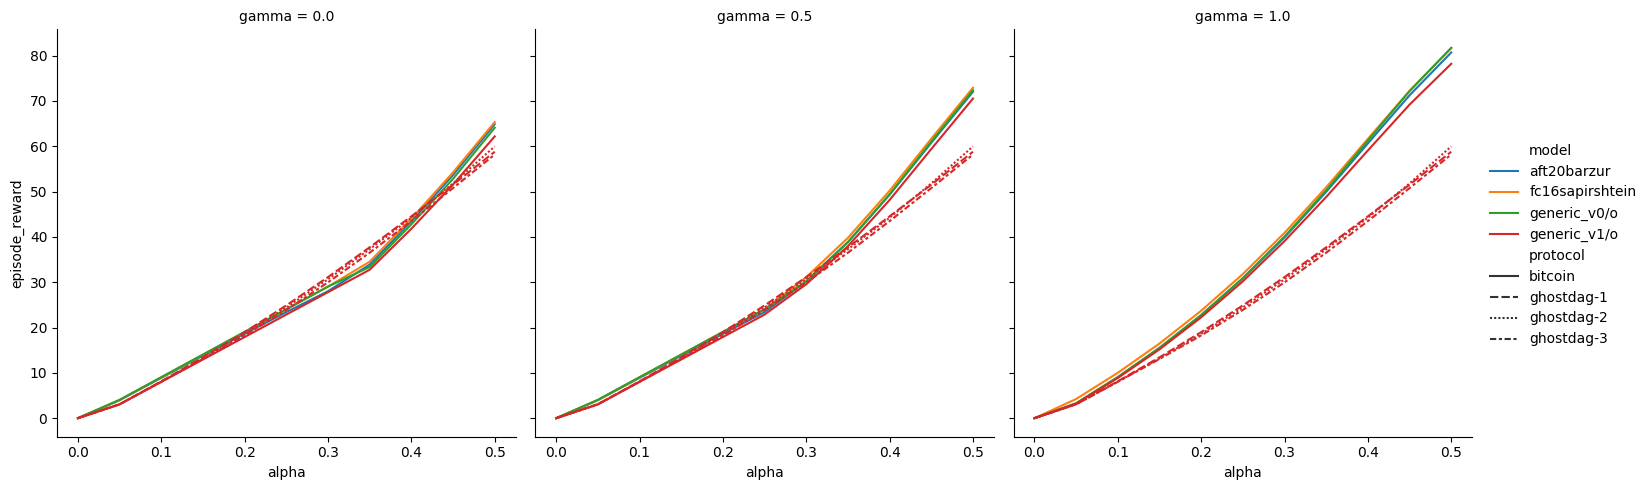

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="gamma",
    hue="model",
    style="protocol",
)

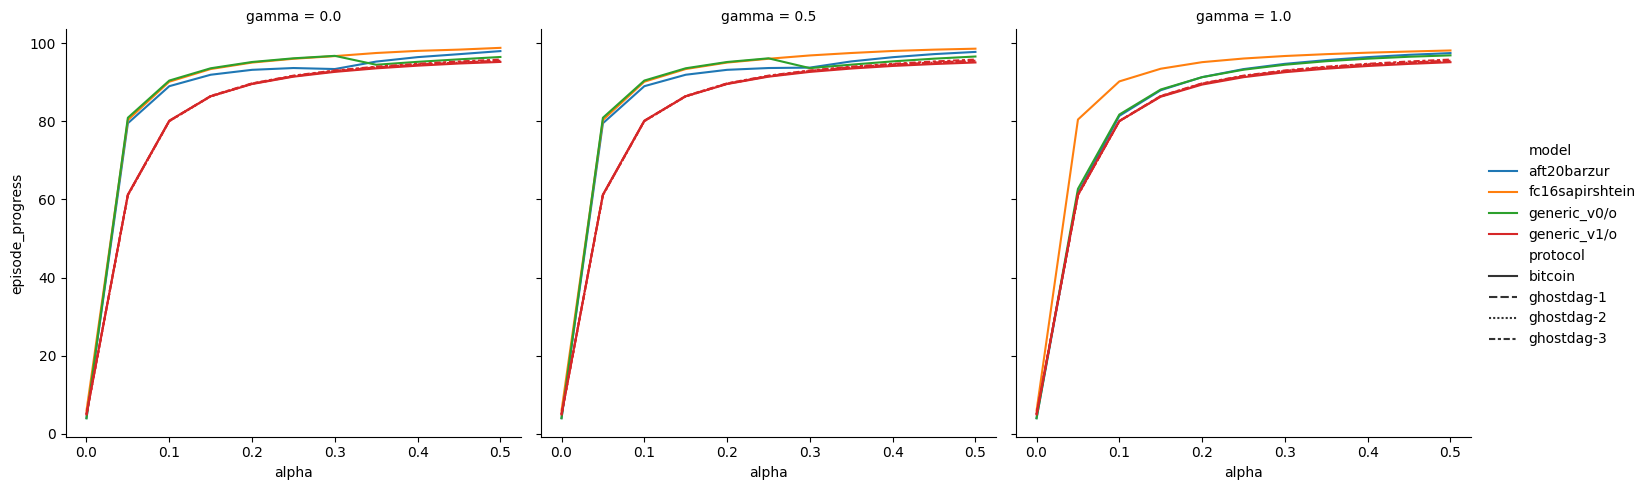

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="gamma",
    hue="model",
    style="protocol",
)

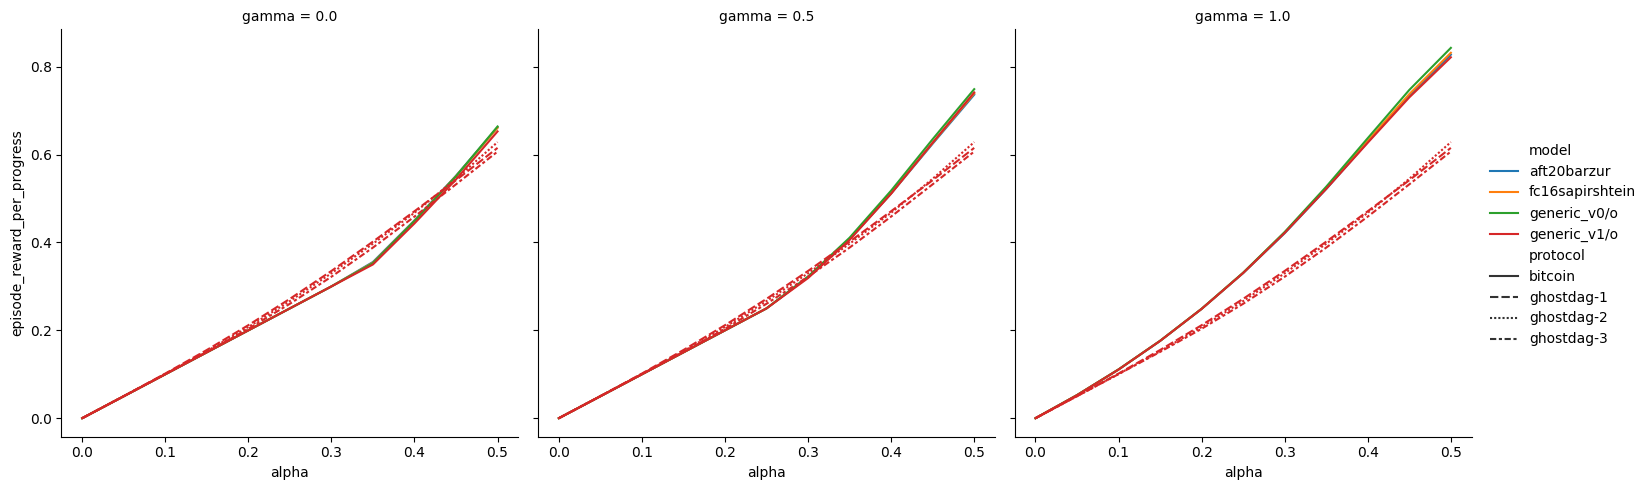

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward_per_progress",
    col="gamma",
    hue="model",
    style="protocol",
)

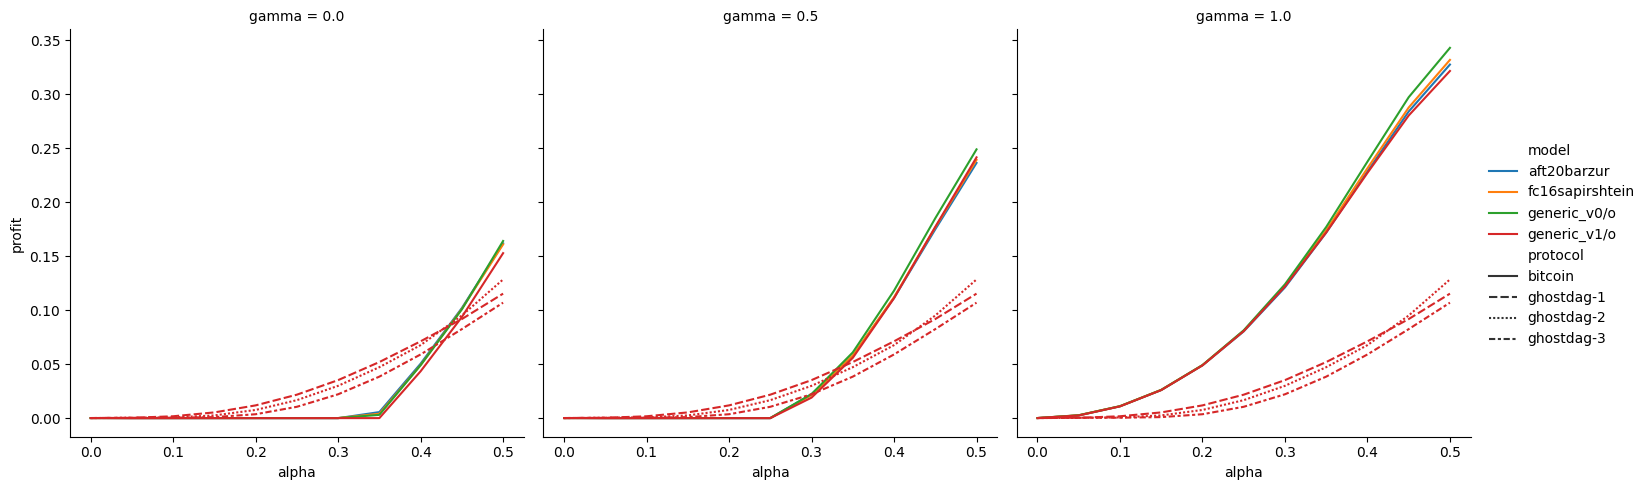

In [9]:
seaborn.relplot(
    data=df.assign(profit=df.episode_reward_per_progress - df.alpha),
    kind="line",
    x="alpha",
    y="profit",
    col="gamma",
    hue="model",
    style="protocol",
)